## Convolutional Neural Networks (CNN)
### Image classification
#### source:  Deep learning with Pytorch book 
Ricardo Flores, www.rflores.cl

### Step 0: Cargar librerias

In [2]:
from torchvision import datasets
from torchvision import transforms 
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import datetime

### Steps 1: Datos

Es posible cargar _datasets_ típicos y _benchmark_ utilizados para probar y experimentar (e.g. CIFAR10, Imagenet, MNIST) directamente
con PyTorch modulo [Torchvision](https://pytorch.org/vision/stable/datasets.html).


In [3]:
# Loading CIFAR10 dataset
data_path = './data/'
#cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)      # train
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # test


Files already downloaded and verified
Files already downloaded and verified


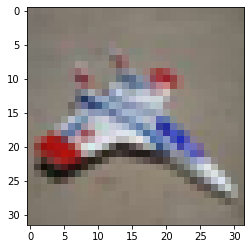

In [4]:
# Plot one image
img, label = cifar10[30]
plt.imshow(img)
plt.show()

In [8]:
# Transform data to pytorch tensor, and normalization
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


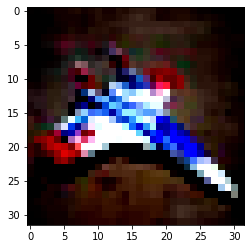

In [9]:
# Plot transformed image
img_t, _ = cifar10[30]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [10]:
# Select birds and airplanes
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

### Step 2: Modelo

In [18]:
# Model 
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # convolutional layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolutional layer
        self.fc1 = nn.Linear(8 * 8 * 8, 32)                     # Fully connected
        self.fc2 = nn.Linear(32, 2)                             # Fully connected
    def forward(self, x): # input img
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)        # max pooling
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)      # max pooling
        out = out.view(-1, 8 * 8 * 8)                           # tranform the out
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out  # dim: number of class

In [19]:
# Training function 
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 
        for imgs, labels in train_loader:  # batch 
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()               # backpro
            optimizer.step()              # update w
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(epoch,
            loss_train / len(train_loader)))
            loss_list.append(loss_train / len(train_loader))
    return loss_list
            

In [21]:
# Dataloader
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [25]:
# Run, traning
model = CNN()                                      # call our cnn class
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Stochastic gradient descent
loss_fn = nn.CrossEntropyLoss()                    # Loss function

Loss1 = training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


Epoch 1, Training loss 0.5845507804755192
Epoch 10, Training loss 0.335722461058076
Epoch 20, Training loss 0.3013656667083692
Epoch 30, Training loss 0.2776144940382356
Epoch 40, Training loss 0.25782008184369204
Epoch 50, Training loss 0.24051546732521362


Text(0, 0.5, 'Loss')

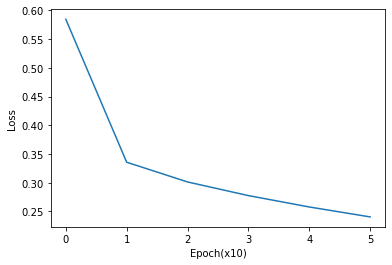

In [26]:
# plot loss
plt.plot(Loss1)
plt.xlabel('Epoch(x10)')
plt.ylabel('Loss')

### Step 3: Resultados

In [27]:
# Testing metric
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                            shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                # metrics: Acc, F1, AUC, Precision, Recall, 
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)


Accuracy train: 0.89
Accuracy val: 0.88
